# Movie Recommendation System
**Dataset:** MovieLens 100k  
**Goal:** Recommend movies to users based on user similarity and evaluate performance using Precision@K.

**Covered Topics:**  
- User-based collaborative filtering  
- Item-based collaborative filtering (bonus)  
- Matrix factorization (SVD, bonus)  
- Precision@K evaluation  
- Visual comparison of recommendation methods


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# For SVD (Surprise)
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV

# --- Load Data ---
import os

Load Data

In [2]:
data_path = "ml-100k"

ratings = pd.read_csv(
    os.path.join(data_path, "u.data"),
    sep="\t",
    names=["user_id","movie_id","rating","timestamp"]
)

movies = pd.read_csv(
    os.path.join(data_path, "u.item"),
    sep="|",
    encoding="latin-1",
    usecols=[0,1],
    names=["movie_id","title"]
)

data = ratings.merge(movies, on="movie_id")


In [3]:
data.head()


,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


create user item matrix

In [4]:
user_item_matrix = data.pivot_table(index="user_id", columns="title", values="rating")
user_item_matrix.fillna(0, inplace=True)

Visualize small subset

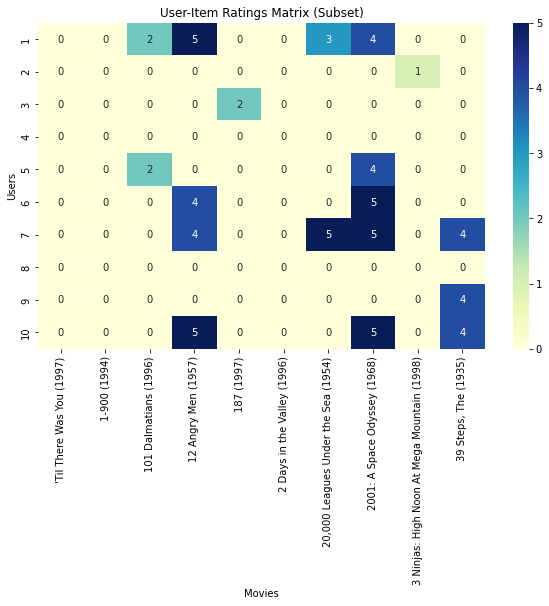

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(user_item_matrix.iloc[:10,:10], annot=True, cmap="YlGnBu")
plt.title("User-Item Ratings Matrix (Subset)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

compute user based collaborative filtering 

In [6]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index
)

In [7]:
def recommend_user_based(user_id, user_item_matrix, user_similarity_df, top_n=5):
    sim_scores = user_similarity_df[user_id]
    weighted_ratings = user_item_matrix.T.dot(sim_scores) / sim_scores.sum()
    user_rated_movies = user_item_matrix.loc[user_id]
    unrated_movies = user_rated_movies[user_rated_movies == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False).head(top_n)
    return recommendations.index.tolist()


In [8]:
print("User-based CF Recommendations for User 1:", recommend_user_based(1, user_item_matrix, user_similarity_df, top_n=5))


User-based CF Recommendations for User 1: ["Schindler's List (1993)", 'E.T. the Extra-Terrestrial (1982)', "One Flew Over the Cuckoo's Nest (1975)", 'English Patient, The (1996)', 'Scream (1996)']


item based collaborative filtering

In [9]:
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns
)

In [10]:
def recommend_item_based(user_id, user_item_matrix, item_similarity_df, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    recommendations = pd.Series(dtype=float)
    for movie, rating in user_ratings[user_ratings > 0].items():
        sim_movies = item_similarity_df[movie].drop(movie)
        recommendations = recommendations.add(sim_movies * rating, fill_value=0)
    recommendations = recommendations.drop(user_ratings[user_ratings > 0].index, errors="ignore")
    return recommendations.sort_values(ascending=False).head(top_n).index.tolist()


Precision@K Evaluation

In [11]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_matrix = train_data.pivot_table(index="user_id", columns="title", values="rating").fillna(0)
test_matrix = test_data.pivot_table(index="user_id", columns="title", values="rating").fillna(0)


In [12]:
user_sim = cosine_similarity(train_matrix)
user_sim_df = pd.DataFrame(user_sim, index=train_matrix.index, columns=train_matrix.index)


In [13]:

def get_top_k_recommendations(user_id, train_matrix, user_sim_df, k=5):
    sim_scores = user_sim_df[user_id]
    weighted_ratings = train_matrix.T.dot(sim_scores) / sim_scores.sum()
    user_rated_movies = train_matrix.loc[user_id]
    unrated_movies = user_rated_movies[user_rated_movies == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False).head(k)
    return recommendations.index.tolist()

In [14]:
def precision_at_k(train_matrix, test_matrix, user_sim_df, k=5):
    precisions = []
    for user_id in test_matrix.index:
        recommended = get_top_k_recommendations(user_id, train_matrix, user_sim_df, k)
        relevant = test_matrix.loc[user_id]
        relevant = relevant[relevant >= 4].index.tolist()
        if len(recommended) > 0:
            precisions.append(len(set(recommended) & set(relevant)) / k)
    return np.mean(precisions)


In [15]:
precision_user_based = precision_at_k(train_matrix, test_matrix, user_sim_df, k=5)


In [16]:
print(f"Precision@5 for User-Based CF: {precision_user_based:.3f}")
print("Item-based CF Recommendations for User 1:", recommend_item_based(1, user_item_matrix, item_similarity_df, top_n=5))



Precision@5 for User-Based CF: 0.227
Item-based CF Recommendations for User 1: ['E.T. the Extra-Terrestrial (1982)', 'Stand by Me (1986)', 'Speed (1994)', 'Batman (1989)', 'True Lies (1994)']


SVD (Surprise)

In [17]:
reader = Reader(line_format="user item rating timestamp", sep="\t")
surprise_data = Dataset.load_from_file(os.path.join(data_path,"u.data"), reader=reader)

trainset, testset = surprise_train_test_split(surprise_data, test_size=0.2, random_state=42)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)

RMSE

In [18]:
rmse = accuracy.rmse(predictions)

RMSE: 0.9370


Precision@K for SVD

In [19]:
def recommend_svd(user_id, model, movies_df, user_item_matrix, top_n=5):
    user_unrated = movies_df[~movies_df["movie_id"].isin(
        user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    )].copy()
    user_unrated["pred_rating"] = user_unrated["movie_id"].apply(lambda x: model.predict(user_id, x).est)
    return user_unrated.sort_values("pred_rating", ascending=False).head(top_n)["title"].tolist()


In [20]:
print(" SVD Recommendations for User 1:", recommend_svd(1, svd_model, movies, user_item_matrix, top_n=5))


 SVD Recommendations for User 1: ['Toy Story (1995)', 'Firestorm (1998)', 'Chungking Express (1994)', 'Heidi Fleiss: Hollywood Madam (1995) ', 'Truman Show, The (1998)']


In [21]:
def precision_at_k_svd(predictions, model, movies_df, user_item_matrix, k=5):
    # Organize predictions by user
    from collections import defaultdict
    user_estimates = defaultdict(list)
    for pred in predictions:
        uid = int(pred.uid)
        iid = int(pred.iid)
        true_r = pred.r_ui
        est = pred.est
        user_estimates[uid].append((iid, true_r, est))
    
    precisions = []
    for uid, user_preds in user_estimates.items():
        # Get top-k recommendations
        recommended = recommend_svd(uid, model, movies_df, user_item_matrix, top_n=k)
        
        # Relevant items (true rating >= 4)
        relevant = [movies_df.loc[movies_df["movie_id"] == iid, "title"].values[0]
                    for iid, true_r, _ in user_preds if true_r >= 4]
        
        if recommended and relevant:
            hits = len(set(recommended) & set(relevant))
            precisions.append(hits / k)
    
    return np.mean(precisions) if precisions else 0


In [22]:
precision_svd = precision_at_k_svd(predictions, svd_model, movies, user_item_matrix, k=5)


In [27]:
def precision_at_k_item_based(train_matrix, test_matrix, item_similarity_df, k=5):
    precisions = []
    for user_id in test_matrix.index:
        recommended = recommend_item_based(user_id, train_matrix, item_similarity_df, top_n=k)
        relevant = test_matrix.loc[user_id]
        relevant = relevant[relevant >= 4].index.tolist()
        if recommended and relevant:
            hits = len(set(recommended) & set(relevant))
            precisions.append(hits / k)
    return np.mean(precisions) if precisions else 0

precision_item_based = precision_at_k_item_based(train_matrix, test_matrix, item_similarity_df, k=5)


Results 

In [28]:
print("🎬 Recommendations for User 1")
print("-"*50)
print("User-based CF:", recommend_user_based(1, user_item_matrix, user_similarity_df, top_n=5))
print("Item-based CF:", recommend_item_based(1, user_item_matrix, item_similarity_df, top_n=5))
print("SVD:", recommend_svd(1, svd_model, movies, user_item_matrix, top_n=5))
print()

print("📊 Precision@5 Results")
print(f"User-based CF: {precision_user_based:.3f}")
print(f"Item-based CF: {precision_item_based:.3f}")
print(f"SVD: {precision_svd:.3f}")
print(f"SVD RMSE: {rmse:.3f}")

🎬 Recommendations for User 1
--------------------------------------------------
User-based CF: ["Schindler's List (1993)", 'E.T. the Extra-Terrestrial (1982)', "One Flew Over the Cuckoo's Nest (1975)", 'English Patient, The (1996)', 'Scream (1996)']
Item-based CF: ['E.T. the Extra-Terrestrial (1982)', 'Stand by Me (1986)', 'Speed (1994)', 'Batman (1989)', 'True Lies (1994)']
SVD: ['Toy Story (1995)', 'Firestorm (1998)', 'Chungking Express (1994)', 'Heidi Fleiss: Hollywood Madam (1995) ', 'Truman Show, The (1998)']

📊 Precision@5 Results
User-based CF: 0.227
Item-based CF: 0.311
SVD: 0.014
SVD RMSE: 0.937


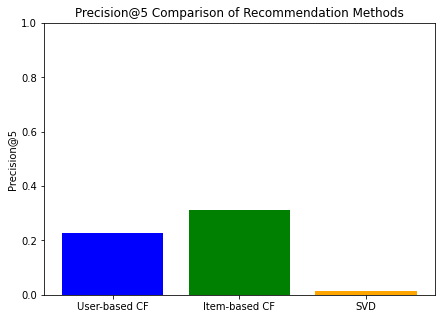

In [29]:
plt.figure(figsize=(7,5))
methods = ["User-based CF", "Item-based CF", "SVD"]
scores = [precision_user_based, precision_item_based, precision_svd]
plt.bar(methods, scores, color=["blue","green","orange"])
plt.ylabel("Precision@5")
plt.title("Precision@5 Comparison of Recommendation Methods")
plt.ylim(0, 1)
plt.show()

In [25]:
# =================================================
# SIDE-BY-SIDE RECOMMENDATIONS FOR USER 1
# =================================================
target_user = 1

user_based_recs = recommend_user_based(target_user, user_item_matrix, user_similarity_df, top_n=5)
item_based_recs = recommend_item_based(target_user, user_item_matrix, item_similarity_df, top_n=5)
svd_recs = recommend_svd(target_user, svd_model, movies, user_item_matrix, top_n=5)

print(f"🎬 Recommendations for User {target_user}")
print("="*50)
print("User-based CF:", user_based_recs)
print("Item-based CF:", item_based_recs)
print("SVD:", svd_recs)

# Optional: Display in DataFrame for nicer comparison
comparison_df = pd.DataFrame({
    "User-based CF": user_based_recs,
    "Item-based CF": item_based_recs,
    "SVD": svd_recs
})
comparison_df


🎬 Recommendations for User 1
User-based CF: ["Schindler's List (1993)", 'E.T. the Extra-Terrestrial (1982)', "One Flew Over the Cuckoo's Nest (1975)", 'English Patient, The (1996)', 'Scream (1996)']
Item-based CF: ['E.T. the Extra-Terrestrial (1982)', 'Stand by Me (1986)', 'Speed (1994)', 'Batman (1989)', 'True Lies (1994)']
SVD: ['Toy Story (1995)', 'Firestorm (1998)', 'Chungking Express (1994)', 'Heidi Fleiss: Hollywood Madam (1995) ', 'Truman Show, The (1998)']


,User-based CF,Item-based CF,SVD
0,Schindler's List (1993),E.T. the Extra-Terrestrial (1982),Toy Story (1995)
1,E.T. the Extra-Terrestrial (1982),Stand by Me (1986),Firestorm (1998)
2,One Flew Over the Cuckoo's Nest (1975),Speed (1994),Chungking Express (1994)
3,"English Patient, The (1996)",Batman (1989),Heidi Fleiss: Hollywood Madam (1995)
4,Scream (1996),True Lies (1994),"Truman Show, The (1998)"


In [ ]:

# Define parameter grid for SVD
param_grid = {
    'n_factors': [50, 100, 150],     # latent factors
    'n_epochs': [20, 40, 60],        # training epochs
    'lr_all': [0.002, 0.005, 0.01],  # learning rates
    'reg_all': [0.02, 0.05, 0.1]     # regularization
}

# Run grid search with cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(surprise_data)

# Print best parameters and scores
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

# Train final SVD model with best parameters
best_params = gs.best_params['rmse']
svd_model = SVD(**best_params)
svd_model.fit(trainset)

# Evaluate again
predictions = svd_model.test(testset)
rmse = accuracy.rmse(predictions)

# Recompute Precision@5 for SVD
precision_svd = precision_at_k_svd(predictions, svd_model, movies, user_item_matrix, k=5)

print(f"Tuned SVD Precision@5: {precision_svd:.3f}")
print(f"Tuned SVD RMSE: {rmse:.3f}")


Best RMSE score: 0.9179755852419619
Best parameters: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.9118
Tuned SVD Precision@5: 0.014
Tuned SVD RMSE: 0.912


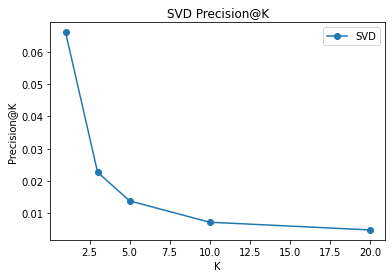

In [32]:
ks = [1, 3, 5, 10, 20]
precisions_svd = [precision_at_k_svd(predictions, svd_model, movies, user_item_matrix, k=k) for k in ks]

plt.plot(ks, precisions_svd, marker='o', label="SVD")
plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title("SVD Precision@K")
plt.legend()
plt.show()
